In [ ]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset",
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

labels = dataset.class_names
labels

Found 6900 files belonging to 80 classes.


['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'Astma_weed',
 'Badipala',
 'Balloon_Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Bhrami',
 'Bringaraja',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chakte',
 'Chilly',
 'Citron lime (herelikai)',
 'Coffee',
 'Common rue(naagdalli)',
 'Coriender',
 'Curry',
 'Doddpathre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganigale',
 'Ganike',
 'Gasagase',
 'Ginger',
 'Globe Amarnath',
 'Guava',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jackfruit',
 'Jasmine',
 'Kambajala',
 'Kasambruga',
 'Kohlrabi',
 'Lantana',
 'Lemon',
 'Lemongrass',
 'Malabar_Nut',
 'Malabar_Spinach',
 'Mango',
 'Marigold',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nerale',
 'Nooni',
 'Onion',
 'Padri',
 'Palak(Spinach)',
 'Papaya',
 'Parijatha',
 'Pea',
 'Pepper',
 'Pomoegranate',
 'Pumpkin',
 'Raddish',
 'Rose',
 'Sampige',
 'Sapota',
 'Seethaashoka',
 'Seethapala',
 'Spinach1',
 'Tamarind',
 'Taro',
 'Tecoma',
 'Thumbe',
 'Tomato',
 'Tulsi',
 'Turmeric',
 'ashoka',
 'camphor',
 

In [3]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break 

(32, 299, 299, 3)
[49 13  4 32 46 54 15 19 74 66 10  2 53 17  8 11  9 21  0 29 32 52 13 21
  8  7 30 17 27  1 78 64]


In [4]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(172, 43)

In [5]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [6]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(172, 43, 1)

In [7]:

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(299, 299),
    tf.keras.layers.Rescaling(1./255)
])

In [8]:
# train using Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=15
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        10,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,134,072 (80.62 MB)

 Trainable params: 272,592 (1.04 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
I0000 00:00:1733553244.492926     169 service.cc:145] XLA service 0x7c5f8c038d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733553244.492973     169 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/172 ━━━━━━━━━━━━━━━━━━━━ 5:00:26 105s/step - accuracy: 0.0312 - loss: 4.3488

I0000 00:00:1733553254.528650     169 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1354 - loss: 3.8325

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 204s 576ms/step - accuracy: 0.1359 - loss: 3.8295 - val_accuracy: 0.5938 - val_loss: 2.0193
Epoch 2/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4934 - loss: 2.0741

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 156s 515ms/step - accuracy: 0.4936 - loss: 2.0731 - val_accuracy: 0.8125 - val_loss: 0.9614
Epoch 3/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6420 - loss: 1.4169

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 157s 514ms/step - accuracy: 0.6420 - loss: 1.4165 - val_accuracy: 0.6875 - val_loss: 1.1138
Epoch 4/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7310 - loss: 1.0667

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 155s 522ms/step - accuracy: 0.7311 - loss: 1.0665 - val_accuracy: 0.9062 - val_loss: 0.6374
Epoch 5/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7868 - loss: 0.8376

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 156s 508ms/step - accuracy: 0.7868 - loss: 0.8375 - val_accuracy: 0.9062 - val_loss: 0.5166
Epoch 6/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8128 - loss: 0.7284

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 156s 517ms/step - accuracy: 0.8128 - loss: 0.7284 - val_accuracy: 0.8438 - val_loss: 0.5521
Epoch 7/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8422 - loss: 0.6009

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 153s 507ms/step - accuracy: 0.8423 - loss: 0.6008 - val_accuracy: 0.9375 - val_loss: 0.3299
Epoch 8/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8625 - loss: 0.5104

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 154s 505ms/step - accuracy: 0.8625 - loss: 0.5104 - val_accuracy: 0.9062 - val_loss: 0.3780
Epoch 9/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8936 - loss: 0.4367

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 204s 514ms/step - accuracy: 0.8936 - loss: 0.4368 - val_accuracy: 0.9688 - val_loss: 0.2388
Epoch 10/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8990 - loss: 0.3950

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 155s 505ms/step - accuracy: 0.8990 - loss: 0.3950 - val_accuracy: 0.9688 - val_loss: 0.2024
Epoch 11/15


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9190 - loss: 0.3345

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 156s 511ms/step - accuracy: 0.9190 - loss: 0.3345 - val_accuracy: 1.0000 - val_loss: 0.1682
Epoch 12/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  1/172 ━━━━━━━━━━━━━━━━━━━━ 3:14:40 68s/step - accuracy: 0.9375 - loss: 0.3791

Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9306 - loss: 0.3087

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 154s 502ms/step - accuracy: 0.9306 - loss: 0.3086 - val_accuracy: 1.0000 - val_loss: 0.0827
Epoch 13/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9368 - loss: 0.2615

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 155s 515ms/step - accuracy: 0.9367 - loss: 0.2615 - val_accuracy: 0.9375 - val_loss: 0.1576
Epoch 14/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9379 - loss: 0.2432

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 155s 505ms/step - accuracy: 0.9379 - loss: 0.2432 - val_accuracy: 1.0000 - val_loss: 0.0871
Epoch 15/15


Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9512 - loss: 0.2135

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


172/172 ━━━━━━━━━━━━━━━━━━━━ 155s 505ms/step - accuracy: 0.9512 - loss: 0.2136 - val_accuracy: 1.0000 - val_loss: 0.0743


In [10]:
model.evaluate(test_ds)

Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 110ms/step - accuracy: 0.9936 - loss: 0.0727


[0.07804422080516815, 0.9912790656089783]

In [11]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Aloevera/10.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to Aloevera with a 73.10 percent confidence.


In [12]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Amruthaballi/484.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to Amruthaballi with a 68.33 percent confidence.


In [17]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/sample1/WhatsApp Image 2024-12-07 at 10.51.11 AM (2).jpeg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to Citron lime (herelikai) with a 69.64 percent confidence.


In [13]:
# import numpy as np

# img = tf.keras.preprocessing.image.load_img(
#     '/kaggle/input/test-medicinal-leaves/bamboo.jpeg', target_size=(299, 299)
# )
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create a batch
# predictions = model.predict(img_array)
# score = tf.nn.sigmoid(predictions[0])
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(labels[np.argmax(score)], 100 * np.max(score))
# )

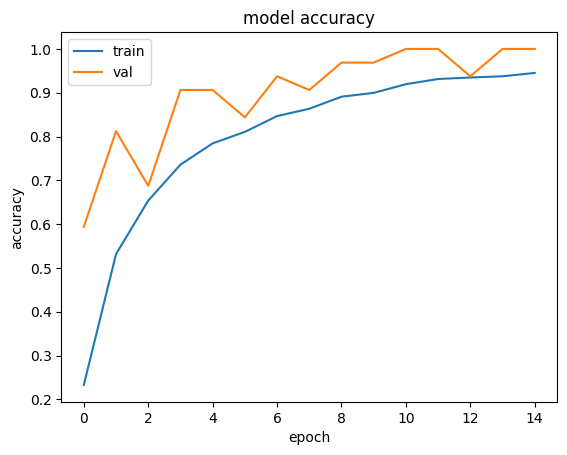

In [14]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
model.save('trained_modelnew.h5') 